In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import BasicAer, transpile
from qiskit.visualization import plot_histogram

In [2]:
ctrl = QuantumRegister(14,'control')
target = QuantumRegister(1,'target')
count = QuantumRegister(4,'count')
result = ClassicalRegister(1,'result')
qc = QuantumCircuit(ctrl,target,count,result)

# ip = all 0

In [3]:
def custom_qft(data_qubits):
        qr_data = QuantumRegister(data_qubits)
        qc = QuantumCircuit(qr_data)
        i = data_qubits
        while i>=1:
            n = i - 1
            qc.h(qr_data[n]) 
            for qubit in range(n):
                qc.cp(np.pi/2**(n-qubit), qr_data[qubit], qr_data[n])
            i = i-1

        return qc

# function to add 1 to register
def subroutine_add_const(count_qubits):
        qc = QuantumCircuit(count_qubits)
        for i in range(count_qubits):
            angle = np.pi/(2**i)
            qc.p(angle,i)
        return qc.to_gate(label="Add 1")
count_qubits = 4

In [4]:
# add 1 to count register if control[i]=1
qft_gate = custom_qft(count_qubits).to_gate()
qc.append(qft_gate,count[:])
add_gate = subroutine_add_const(count_qubits).control(1)
for i in range(14):
    temp = [ctrl[i]]
    for c in count:
        temp.append(c)
    qc.append(add_gate,temp)
inverse_qft_gate = custom_qft(count_qubits).inverse().to_gate()
qc.append(inverse_qft_gate,count[:])


# q3q2q1q0 - 1110 if all 14 qubits are 1
qc.x(count[0])
qc.mct(count,target)
qc.x(count[0])

# Uncompute count register - subtract 1 to count register if control[i]=1
qc.append(qft_gate,count[:])
inverse_add_gate = subroutine_add_const(count_qubits).inverse().control(1)
for i in range(14):
    temp = [ctrl[i]]
    for c in count:
        temp.append(c)
    qc.append(inverse_add_gate,temp)
qc.append(inverse_qft_gate,count[:])

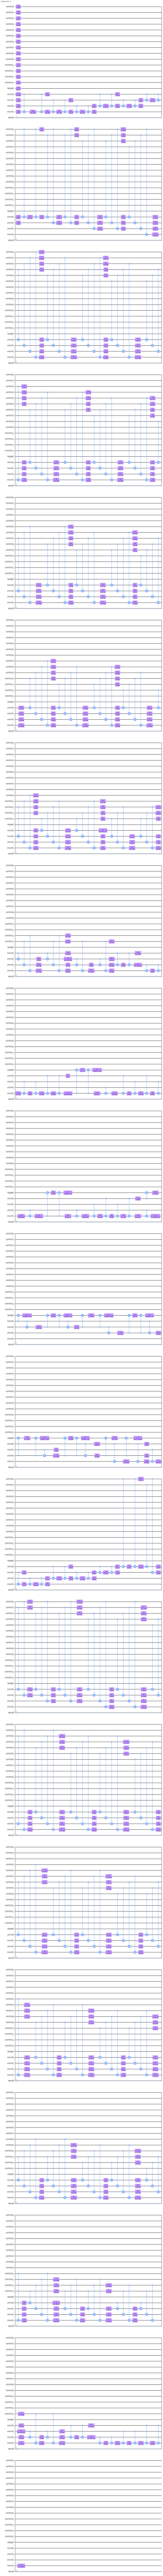

In [5]:
qc = qc.decompose()
qc = qc.decompose()
qc = transpile(qc, basis_gates=['cx','u'])
qc.draw(output='mpl')

In [8]:
print(qc.depth())
print(qc.count_ops())

277
OrderedDict([('u', 450), ('cx', 308)])


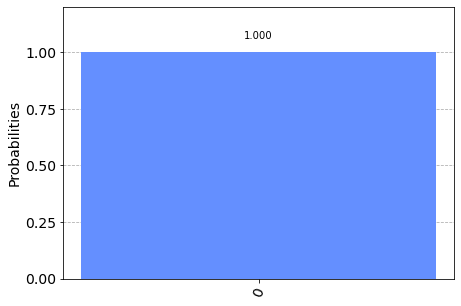

In [9]:
qc.measure(target,result)
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend,shots=1024)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

277
OrderedDict([('u', 450), ('cx', 308)])


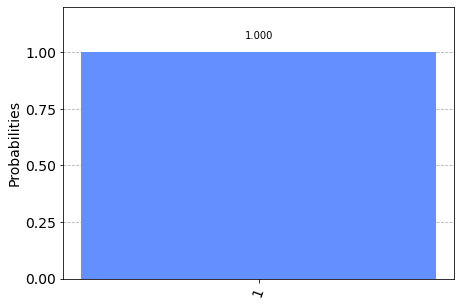

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import BasicAer, transpile
from qiskit.visualization import plot_histogram

ctrl = QuantumRegister(14,'control')
target = QuantumRegister(1,'target')
count = QuantumRegister(4,'count')
result = ClassicalRegister(1,'result')
qc = QuantumCircuit(ctrl,target,count,result)

# ip = all 1s

qc.x(ctrl[:])

def custom_qft(data_qubits):
        qr_data = QuantumRegister(data_qubits)
        qc = QuantumCircuit(qr_data)
        i = data_qubits
        while i>=1:
            n = i - 1
            qc.h(qr_data[n]) 
            for qubit in range(n):
                qc.cp(np.pi/2**(n-qubit), qr_data[qubit], qr_data[n])
            i = i-1

        return qc

# function to add 1 to register
def subroutine_add_const(count_qubits):
        qc = QuantumCircuit(count_qubits)
        for i in range(count_qubits):
            angle = np.pi/(2**i)
            qc.p(angle,i)
        return qc.to_gate(label="Add 1")
count_qubits = 4

# add 1 to count register if control[i]=1
qft_gate = custom_qft(count_qubits).to_gate()
qc.append(qft_gate,count[:])
add_gate = subroutine_add_const(count_qubits).control(1)
for i in range(14):
    temp = [ctrl[i]]
    for c in count:
        temp.append(c)
    qc.append(add_gate,temp)
inverse_qft_gate = custom_qft(count_qubits).inverse().to_gate()
qc.append(inverse_qft_gate,count[:])


# q3q2q1q0 - 1110 if all 14 qubits are 1
qc.x(count[0])
qc.mct(count,target)
qc.x(count[0])

# Uncompute count register - subtract 1 to count register if control[i]=1
qc.append(qft_gate,count[:])
inverse_add_gate = subroutine_add_const(count_qubits).inverse().control(1)
for i in range(14):
    temp = [ctrl[i]]
    for c in count:
        temp.append(c)
    qc.append(inverse_add_gate,temp)
qc.append(inverse_qft_gate,count[:])

qc = qc.decompose()
qc = qc.decompose()
qc = transpile(qc, basis_gates=['cx','u'])
qc.draw(output='mpl')


print(qc.depth())
print(qc.count_ops())

qc.measure(target,result)
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc,backend,shots=1024)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

# Qiskit's deafult MCX gate (for comparison)

In [10]:
q1 = QuantumRegister(14)
q2 = QuantumRegister(1)
qc = QuantumCircuit(q1,q2)
qc.mcx(q1[:],q2[0])

In [11]:
qc = qc.decompose()
qc = qc.decompose()
qc = transpile(qc, basis_gates=['cx','u'])
print(qc.depth())
print(qc.count_ops())

81915
OrderedDict([('u', 49150), ('cx', 49148)])


In [ ]:
# Counting the number of qubits in state |1> in control register and keeping their ciunt stored in count register.
# subroutine_add_const is applied on count register controlled by control qubit (i.e if control qubit is |1>, 
# 1 will be added to count reguster). 
# If all control qubits are |1>, count register will be |1110>, which we can use to flip target qubit.